## Poročilo vaja 1.1
#### Opisna statistika v članku: An empirical study of race times in recreational endurance runners

Na podatkih iz članka: "**An empirical study of race times in recreational endurance runners**":
1. Pretvori podatke iz Excela:
   - Pri tem ustrezno uredi spremenljivke
   - Dodaj še kategorijo maraton <3h (da/ne)
   - V članku je še en izračun predikcije maratonskega časa po Rieglerjevem modelu, ki je čas maratona/čas krajše razdalje = (razdalja maratona/razdalja krajše)^k, k = 1.07
2. Izvedi opisne statistike, ki so v članku
   - Opisne statistike v Tabeli 1 in 2
   - Dodaj še opisno statistiko za primerjavo skupine Maraton < 3h proti ostalim.
3. Grafi:
   - Nekatere opisne statistike opremi še z grafi.
   - Naredi grafe primerjave med skupino Maraton < 3h proti ostalim.
   - Naredi grafe raztrosa za ugotavljanje povezave med skalarnimi spremenljivkami in časom maratona.

In [5]:
import numpy as np
import pandas as pd
import os
from tabulate import tabulate
from datetime import timedelta
from scipy.stats import shapiro
import seaborn as sns
import matplotlib.pyplot as plt

path = os.getcwd()
data = pd.read_excel(path + "\\data\\running_marathon_po_clanku_preproc.xlsx")

In [9]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
# ustrezne spremenljivke nastavimo v kategorijske
for col in data.select_dtypes(include='int64').columns:
    if col != 'id':
        data[col] = data[col].astype('category')

#### 1. Izračun kategorijske spremenljivke **marathon < 3h** in predikcije maratonskega časa po **Rieglerjevem modelu**

In [10]:
# izračun in generacija nove spremenljivke mf_under_3h --> če je 
data['mf_under_3h'] = np.where(data['mf_ti'].isna(), np.nan, data['mf_ti'] < 10800 )

In [11]:
# implementacija Rieglerjeve enačbe za oceno časa potrebnega za dokončanje maratona iz časa teka na 5km
data['mf_riegler'] = ((data['mf_d']/data['k5_d'])**1.07)*data['k5_ti']
# prikaz prvih petih vrstic in pravkar izračunanih in dodanih spremenljivk
data[['age', 'bmi', 'female', 'mf_ti', 'mf_under_3h', 'mf_riegler']].head()

,age,bmi,female,mf_ti,mf_under_3h,mf_riegler
0,25.0,21.622116,1,NaN,NaN,NaN
1,41.0,23.905970,0,NaN,NaN,NaN
2,25.0,21.640728,0,NaN,NaN,NaN
3,35.0,23.592323,0,10295.0,1.0,10532.702565
4,34.0,22.706404,0,NaN,NaN,NaN


#### 2. Opisne statistike po članku z dodano primerjavo Maraton < 3h proti ostalim.

In [12]:
# pridobi in pripravi podatke za izris prve tabele.
N = data.shape[0]

def format_continuous(df, var):
    q1 = df[var].quantile(0.25)
    median = df[var].median()
    q3 = df[var].quantile(0.75)
    return f'{median:.1f} ({q1:.1f}, {q3:.1f})'

def format_categorical(df, var):
    counts = df[var].value_counts(dropna=False).sort_index() 
    total = counts.sum()                                        # count all values
    ones = counts.get(1)                                        # count all 1s
    return f'{ones} ({(ones/total)*100:.1f}%)'
    

def summarize_categorical(df, var, name_row=None, labels=None):
    counts = df[var].value_counts(dropna=False).sort_index()
    total = counts.sum()
    rows = [[var if name_row == None else name_row, '']]  # Name row

    for val, count in counts.items():
        label = labels[val] if labels else str(val)
        percent = (count / total) * 100
        row = [f'  {label}', f'{count} ({percent:.1f}%)']
        rows.append(row)
    return rows

def format_seconds(seconds):
    if pd.isna(seconds):
        return None
    return str(timedelta(seconds=int(seconds)))

def get_race_velocity(time, distance):
    velocity = (time*1609.34)/distance
    return str(timedelta(seconds=int(velocity)))

def bold_rows(row, bold_indices):
    if row.name in bold_indices:
        return ['font-weight: bold']*len(row)
    else:
        return ['']*len(row)

age_summary = format_continuous(data, 'age')
bmi_summary = format_continuous(data, 'bmi')
typical_summary = format_continuous(data, 'typical')

summary_table = []

summary_table.append(['Age', age_summary])
summary_table += summarize_categorical(data, 'female', name_row='Sex', labels={1: '- Female', 0: '- Male'})
summary_table.append(['BMI', bmi_summary])
summary_table += summarize_categorical(data, 'endurancecat', name_row='Type of runner', labels={1: '- Strictly endurance', 2: '- Generally endurance', 3: '- Generally speed', 4: '- Strictly speed'})
summary_table.append(['Typical weekly training mileage', typical_summary])
summary_table += summarize_categorical(data, 'injury', name_row='Any injury during training?', labels={1: '- Nothing that stopped me running', 2: '- Yes, I had to take a fwe days off', 3: '- Yes, I had to take more than a week off from running'})
summary_table += summarize_categorical(data, 'footwear', name_row='Type of footwear', labels={1: '- Minimalist', 2: '- Running Shoe', 3: '- Barefoot'})

summary_df = pd.DataFrame(summary_table, columns=['Variable', 'Summary'])
summary_df.style.set_caption(f'Table 1: Characteristics of study participants (N = {N})')\
          .set_table_styles([
              {'selector': 'caption', 'props': [('font-size', '16px'), 
                                                ('font-weight', 'bold'), 
                                                ('border-bottom', '1px solid black'),
                                                ('width', '100%')]},
              {'selector': 'td', 'props': 'text-align: left;'}
          ])\
          .hide(axis='columns')\
          .hide()

Age,"35.0 (29.0, 42.0)"
Sex,
- Male,1413 (61.4%)
- Female,890 (38.6%)
BMI,"23.4 (21.7, 25.2)"
Type of runner,
- Strictly endurance,706 (30.7%)
- Generally endurance,1287 (55.9%)
- Generally speed,297 (12.9%)
- Strictly speed,13 (0.6%)
Typical weekly training mileage,"30.0 (20.0, 42.0)"


In [13]:
# pridobi in pripravi podatke za izris druge tabele
dist = {'5 km': 'k5_ti', '5 mile': 'm5_ti', '10 km': 'k10_ti', '10 mile': 'm10_ti', 'Half-marathon': 'mh_ti', 'Marathon': 'mf_ti'}
df_t2 = pd.DataFrame(columns=dist.keys(), index=['N', 'Age', 'Female', 'Typical Mileage', 'Intervals', 'Tempo Runs', 'Race Time Male', 'Race Time Female', 'Race Velocity Male', 'Race Velocity Female'])
for key, value in dist.items():
    df = data[data[value].notna()]
    df_t2.loc['N', key] = f'N = {df.shape[0]}'
    df_t2.loc['Age', key] = format_continuous(df, 'age')
    df_t2.loc['Female', key] = format_categorical(df, 'female')
    df_t2.loc['Typical Mileage', key] = format_continuous(df, 'typical')
    df_t2.loc['Intervals', key] = format_categorical(df, 'sprint')
    df_t2.loc['Tempo Runs', key] = format_categorical(df, 'tempo')
    time_male = df.loc[df['female'] == 0, value]
    
    m_median, m_q1, m_q3  = time_male.median(), time_male.quantile(0.25), time_male.quantile(0.75)    
    time_female = df.loc[df['female'] == 1, value]
    f_median, f_q1, f_q3  = time_female.median(), time_female.quantile(0.25), time_female.quantile(0.75)    

    distance = df[value.split('_')[0] + '_d'].mean()
    
    df_t2.loc['Race Time Male', key] = f'{format_seconds(m_median)} ({format_seconds(m_q1)}, {format_seconds(m_q3)})'
    df_t2.loc['Race Time Female', key] = f'{format_seconds(f_median)} ({format_seconds(f_q1)}, {format_seconds(f_q3)})'
    df_t2.loc['Race Velocity Male', key] = f'{get_race_velocity(m_median, distance)} ({get_race_velocity(m_q1, distance)}, {get_race_velocity(m_q3, distance)})'
    df_t2.loc['Race Velocity Female', key] = f'{get_race_velocity(f_median, distance)} ({get_race_velocity(f_q1, distance)}, {get_race_velocity(f_q3, distance)})'
df_t2.style.set_caption(f'Table 2: Age, sex, race training, velocity and time, by race distance')\
          .set_table_styles([
              {'selector': 'caption', 'props': [('font-size', '16px'), 
                                                ('font-weight', 'bold'), 
                                                ('border-bottom', '1px solid black'),
                                                ('width', '100%')]},
              {'selector': 'td', 'props': 'text-align: left;'}
          ])

,5 km,5 mile,10 km,10 mile,Half-marathon,Marathon
N,N = 1387,N = 313,N = 946,N = 357,N = 1579,N = 1022
Age,"34.0 (29.0, 42.0)","34.0 (28.0, 41.0)","35.0 (30.0, 43.0)","34.0 (29.0, 42.0)","35.0 (30.0, 43.0)","35.0 (30.0, 43.0)"
Female,532 (38.4%),106 (33.9%),339 (35.8%),137 (38.4%),686 (43.4%),366 (35.8%)
Typical Mileage,"28.0 (18.0, 40.0)","25.0 (16.0, 40.0)","25.0 (18.0, 40.0)","28.0 (20.0, 40.0)","30.0 (20.0, 40.0)","40.0 (30.0, 50.0)"
Intervals,716 (51.6%),165 (52.7%),462 (48.8%),177 (49.6%),839 (53.1%),579 (56.7%)
Tempo Runs,773 (55.7%),164 (52.4%),535 (56.6%),208 (58.3%),942 (59.7%),684 (66.9%)
Race Time Male,"0:20:35 (0:18:20, 0:23:26)","0:34:59 (0:29:44, 0:40:52)","0:44:51 (0:39:48, 0:51:30)","1:14:21 (1:03:41, 1:23:07)","1:39:06 (1:28:00, 1:52:10)","3:28:02 (3:03:25, 3:57:31)"
Race Time Female,"0:26:01 (0:22:41, 0:29:09)","0:43:34 (0:37:39, 0:49:18)","0:54:58 (0:48:13, 1:02:04)","1:32:00 (1:20:11, 1:44:00)","1:56:31 (1:44:03, 2:12:15)","3:54:35 (3:31:40, 4:29:47)"
Race Velocity Male,"0:06:37 (0:05:54, 0:07:32)","0:06:59 (0:05:56, 0:08:10)","0:07:13 (0:06:24, 0:08:17)","0:07:26 (0:06:22, 0:08:18)","0:07:33 (0:06:42, 0:08:33)","0:07:56 (0:06:59, 0:09:03)"
Race Velocity Female,"0:08:22 (0:07:18, 0:09:22)","0:08:42 (0:07:31, 0:09:51)","0:08:50 (0:07:45, 0:09:59)","0:09:12 (0:08:01, 0:10:24)","0:08:53 (0:07:56, 0:10:05)","0:08:56 (0:08:04, 0:10:17)"


**Test normalnosti skalarjev (age, bmi, typical, k5_ti) s Shapiro-Wilk testom**

Normalnost porazdelitve skalarjev preverimo s Shapiro-Wilk testom. Če je izračunana p vrednost manjša od prej določene mejne vrednosti (najpogosteje 0.05) potem ovržemo ničto hipotezo testa, ki pravi, da je porazdelitev skalarja normalna.

In [40]:
df_3h = data[data['mf_under_3h'].notna()].copy()

variables = ['age', 'bmi', 'typical', 'k5_ti']
for v in variables:
    value = df_3h[v].dropna()
    stat, p = shapiro(value)
    print(f'Shapiro-Wilk Test Statistic for {v}: {stat:.4f}')
    print(f'p-value: {p:.4f}')
    if p < 0.05:
        print(f'    {v} is non-normally distributed.')
    else:
        print(f'    {v} is normally distributed.')

Shapiro-Wilk Test Statistic for age: 0.9600
p-value: 0.0000
    age is non-normally distributed.
Shapiro-Wilk Test Statistic for bmi: 0.9005
p-value: 0.0000
    bmi is non-normally distributed.
Shapiro-Wilk Test Statistic for typical: 0.9423
p-value: 0.0000
    typical is non-normally distributed.
Shapiro-Wilk Test Statistic for k5_ti: 0.9003
p-value: 0.0000
    k5_ti is non-normally distributed.


In [41]:
df_t3 = pd.DataFrame(columns=['nad 3h', 'pod 3h'],
                     index=['N', 'spol (M/Ž)', 'starost', 'BMI', 'pretečeni km/teden', 'čas teka 5km [s]'])
df_under = df_3h[df_3h['mf_under_3h'] == 1.0]
df_above = df_3h[df_3h['mf_under_3h'] == 0.0]
df_t3.loc['N', 'nad 3h'] = len(df_above)
df_t3.loc['N', 'pod 3h'] = len(df_under)
df_t3.loc['spol (M/Ž)', 'nad 3h'] = f'{df_above['female'].value_counts(dropna=False).sort_index().get(0)}/{df_above['female'].value_counts(dropna=False).sort_index().get(1)}'
df_t3.loc['spol (M/Ž)', 'pod 3h'] = f'{df_under['female'].value_counts(dropna=False).sort_index().get(0)}/{df_under['female'].value_counts(dropna=False).sort_index().get(1)}'

for row, value in {'starost': 'age', 'BMI': 'bmi', 'pretečeni km/teden': 'typical', 'čas teka 5km [s]': 'k5_ti'}.items():
    df_t3.loc[row, 'nad 3h'] = f'{df_above[value].median():.1f} ({df_above[value].quantile(0.75)-df_above[value].quantile(0.25):.1f})'
    df_t3.loc[row, 'pod 3h'] = f'{df_under[value].median():.1f} ({df_under[value].quantile(0.75)-df_under[value].quantile(0.25):.1f})'
df_t3.style.set_caption(f'Table 3: Primerjava tekačev, ki so maraton pretekli pod 3h in v 3h ali več')\
          .set_table_styles([
              {'selector': 'caption', 'props': [('font-size', '16px'), 
                                                ('font-weight', 'bold'), 
                                                ('border-bottom', '1px solid black'),
                                                ('width', '650px')]},
              {'selector': 'td', 'props': 'text-align: left;'}
          ])

,nad 3h,pod 3h
N,877,145
spol (M/Ž),519/358,137/8
starost,36.0 (13.0),34.0 (10.0)
BMI,23.3 (3.3),22.1 (2.5)
pretečeni km/teden,37.0 (15.0),60.0 (25.0)
čas teka 5km [s],1267.0 (236.0),1026.0 (77.0)


#### 3. Grafi

V nadaljevanju so prikazani različni grafi, ki vizualno opisujejo lastnosti različnih spremenljivk.

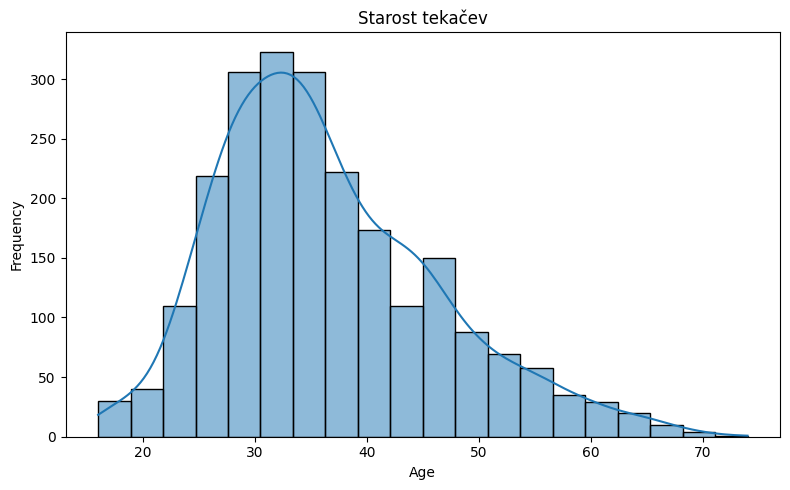

In [42]:
plt.figure(figsize=(8, 5))
sns.histplot(data['age'], bins=20, kde=True)
plt.title('Starost tekačev')
plt.xlabel('Starost')
plt.ylabel('Število tekačev')
plt.tight_layout()
plt.show()

Iz histograma je razvidno, da spremenljivka 'age' ni normalno razporejena.

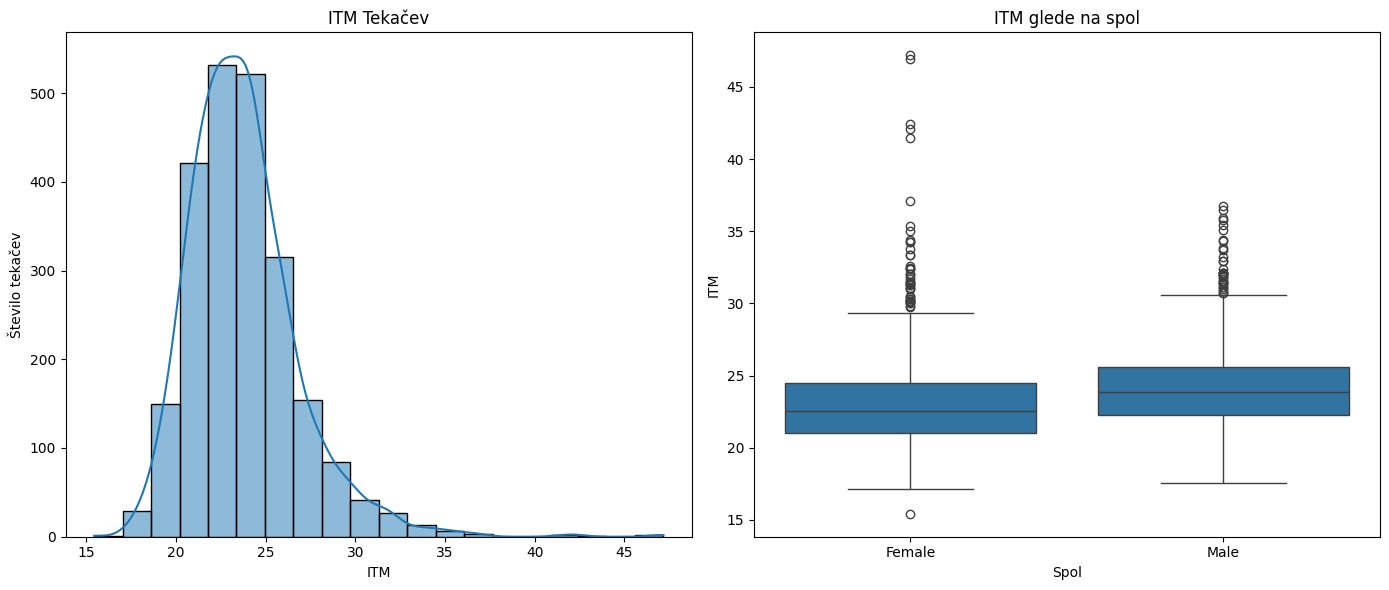

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

data['gender'] = data['female'].map({1: 'Female', 0: 'Male'})

sns.histplot(data['bmi'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('ITM Tekačev')
axes[0].set_xlabel('ITM')
axes[0].set_ylabel('Število tekačev')

sns.boxplot(x='gender', y='bmi', data=data, ax=axes[1])
axes[1].set_title('ITM glede na spol')
axes[1].set_xlabel('Spol')
axes[1].set_ylabel('ITM')

plt.tight_layout()
plt.show()

Iz grafa okvirja z ročaji bi lahko sklepali, da so podatki za indeks telesne mase brez outlier-jev za posamezni spol sicer normalno porazdeljeni (boxplot je simetričen), vendar je otlier-jev preveč. To potrjuje tudi Shapiro-Wilk test.

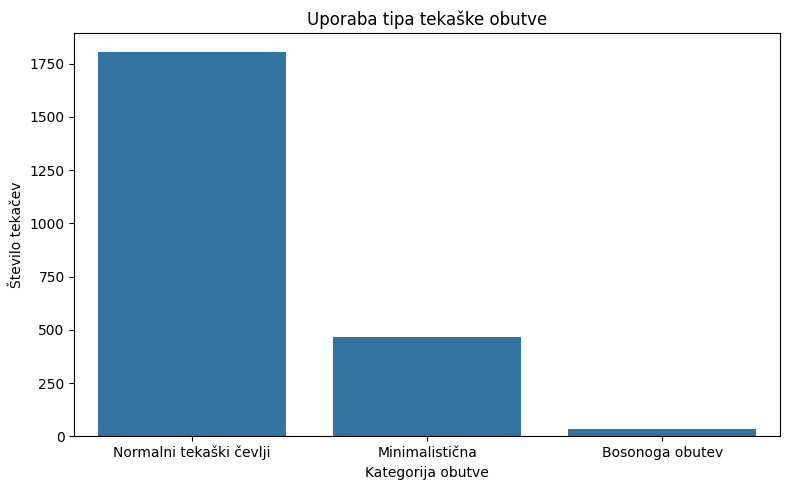

In [49]:
plt.figure(figsize=(8,5))
data['footwear_cat'] = data['footwear'].map({1: 'Minimalistična', 2: 'Normalni tekaški čevlji', 3: 'Bosonoga obutev'})
sns.countplot(x='footwear_cat', data=data)
plt.title('Uporaba tipa tekaške obutve')
plt.xlabel('Kategorija obutve')
plt.ylabel('Število tekačev')
plt.tight_layout()
plt.show()

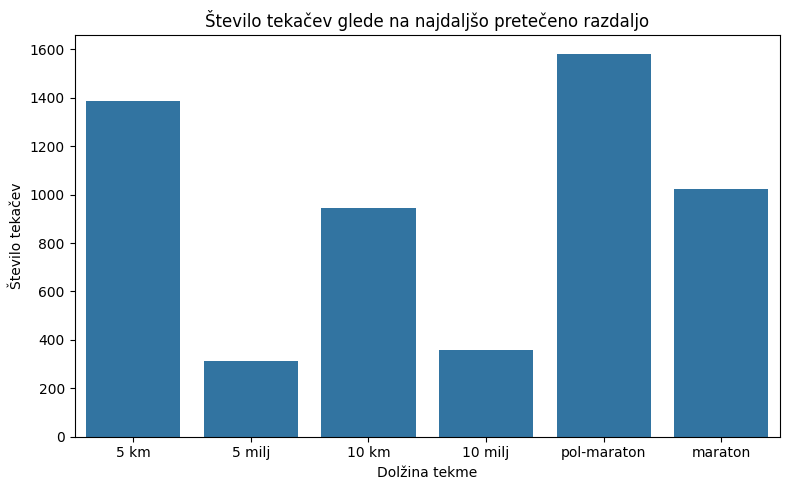

In [50]:
race_columns = ['k5_ti', 'm5_ti', 'k10_ti', 'm10_ti', 'mh_ti', 'mf_ti']
race_completion_counts = data[race_columns].notna().sum()

plt.figure(figsize=(8,5))
ax = sns.barplot(x=race_completion_counts.index, y=race_completion_counts.values)
plt.title('Število tekačev glede na najdaljšo pretečeno razdaljo')
plt.xlabel('Dolžina tekme')
ax.set_xticks(range(len(race_columns)))
ax.set_xticklabels(['5 km', '5 milj', '10 km', '10 milj', 'pol-maraton', 'maraton'])
plt.ylabel('Število tekačev')
plt.tight_layout()
plt.show()

Iz grafa je razvidno, da se največ ljudi prijavi na 5-kilometerske in pol-maratonske razdalje.

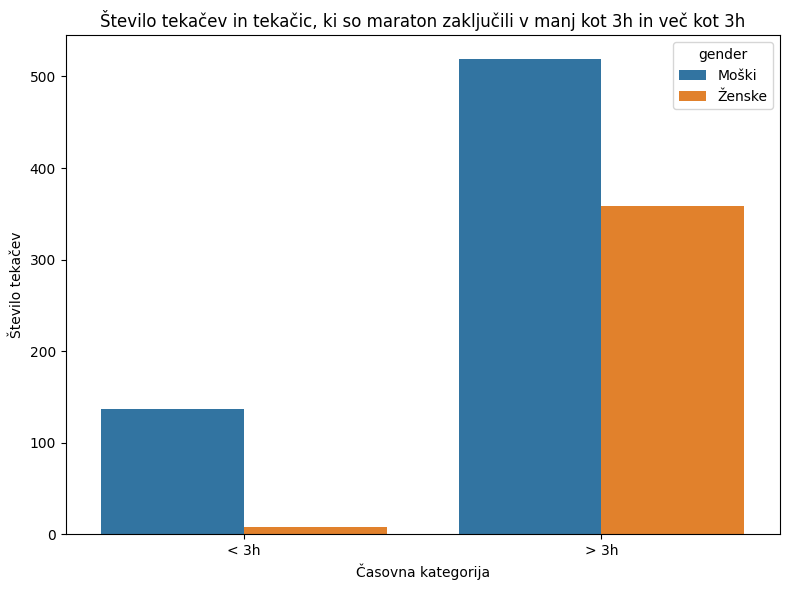

In [51]:
df_3h['time_category'] = df_3h['mf_under_3h'].map({1.0: '< 3h', 0.0: '> 3h'})
df_3h['gender'] = df_3h['female'].map({1: 'Ženske', 0: 'Moški'})
grouped = df_3h.groupby(['gender', 'time_category']).size().reset_index(name='count')

plt.figure(figsize=(8,6))
sns.barplot(x='time_category', y='count', hue='gender', data=grouped)
plt.title('Število tekačev in tekačic, ki so maraton zaključili v manj kot 3h in več kot 3h')
plt.xlabel('Časovna kategorija')
plt.ylabel('Število tekačev')
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Odstotek tekačev')

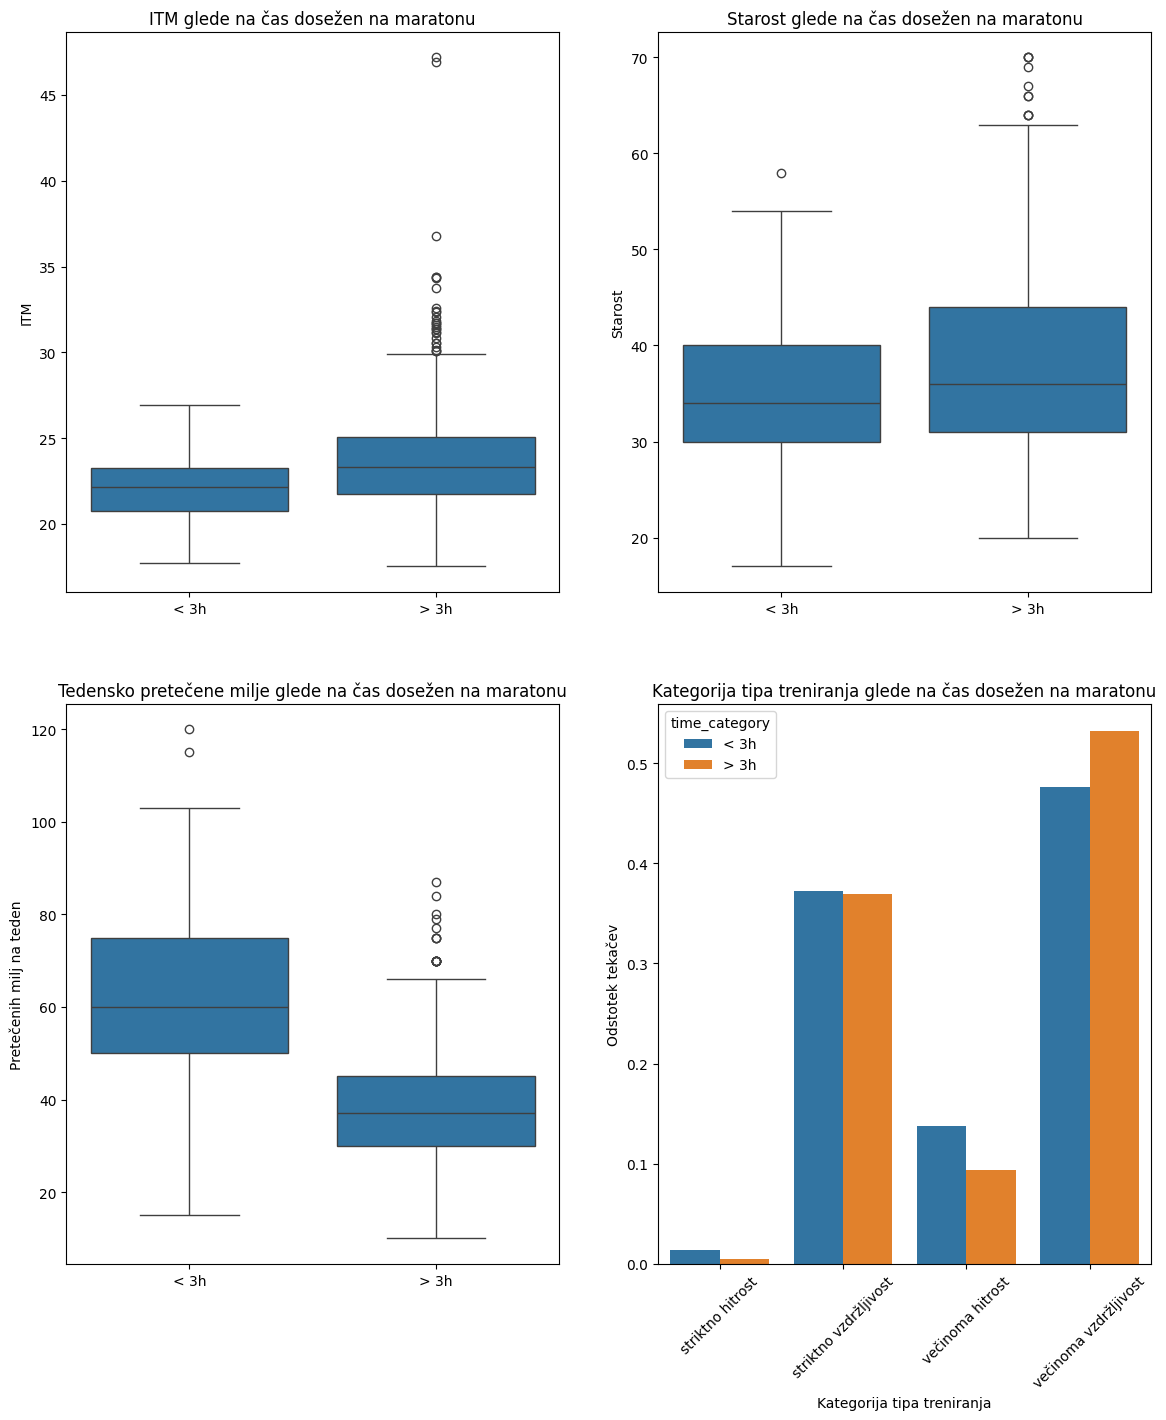

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(14, 16))
plt.xticks(rotation=45)

sns.boxplot(data=df_3h, x='time_category', y='bmi', ax=axes[0, 0])
axes[0, 0].set_title('ITM glede na čas dosežen na maratonu')
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('ITM')

sns.boxplot(data=df_3h, x='time_category', y='age', ax=axes[0, 1])
axes[0, 1].set_title('Starost glede na čas dosežen na maratonu')
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('Starost')

sns.boxplot(data=df_3h, x='time_category', y='typical', ax=axes[1, 0])
axes[1, 0].set_title('Tedensko pretečene milje glede na čas dosežen na maratonu')
axes[1, 0].set_xlabel('')
axes[1, 0].set_ylabel('Pretečenih milj na teden')

df_3h['endurancecat_label'] = df_3h['endurancecat'].map({1: 'striktno vzdržljivost', 2: 'večinoma vzdržljivost', 3: 'večinoma hitrost', 4: 'striktno hitrost'})

count_df = df_3h.groupby(['time_category', 'endurancecat_label']).size().reset_index(name='count')

total_df = count_df.groupby('time_category')['count'].sum().reset_index(name='total')
merged = pd.merge(count_df, total_df, on='time_category')
merged['proportion'] = merged['count'] / merged['total']

sns.barplot(data=merged, x='endurancecat_label', y='proportion', hue='time_category', ax=axes[1, 1])
axes[1, 1].set_title('Kategorija tipa treniranja glede na čas dosežen na maratonu')
axes[1, 1].set_xlabel('Kategorija tipa treniranja')
axes[1, 1].set_ylabel('Odstotek tekačev')


Iz grafov lahko vidimo, da spremenljivki 'bmi' in 'age' verjetno ne vplivata na to ali bo tekač maraton pretekel pod tremi urami ali v treh urah in več. Spodnji levi graf, pa 
kaže precejšen vpliv količine pretečenih kilometrov na končen čas maratona. Graf spodaj desno prikazuje odstotek tekačev, ki trenira na določen način, in kako
to vpliva na končni čas maratona. 

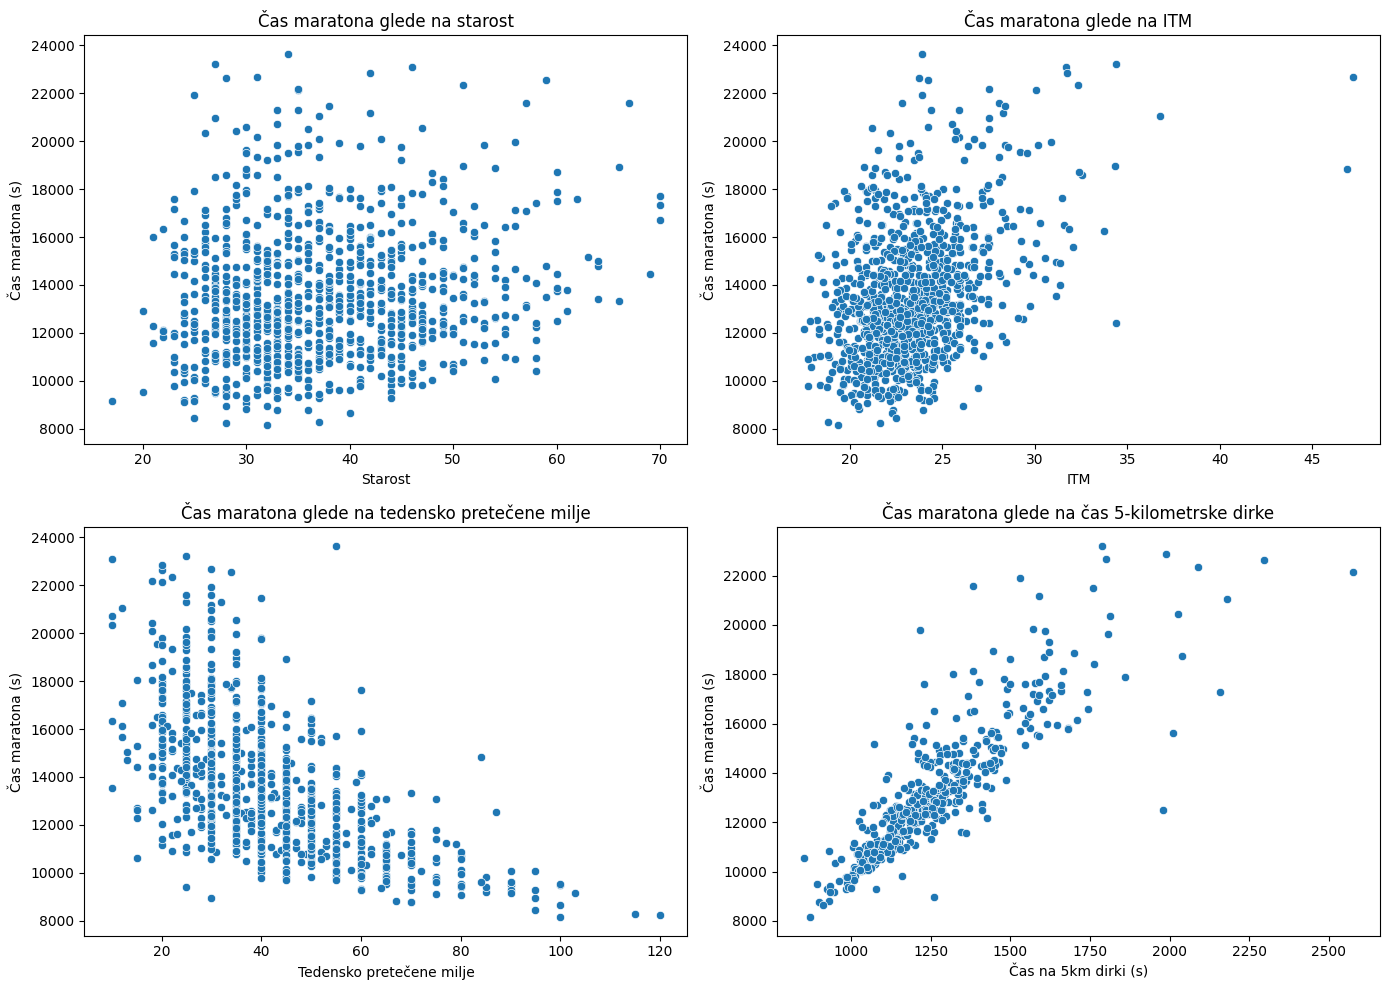

In [53]:
fig, axes = plt.subplots(2, 2, figsize=(14,10))

sns.scatterplot(data=df_3h, x='age', y='mf_ti', ax=axes[0, 0])
axes[0, 0].set_title('Čas maratona glede na starost')
axes[0, 0].set_xlabel('Starost')
axes[0, 0].set_ylabel('Čas maratona (s)')

sns.scatterplot(data=df_3h, x='bmi', y='mf_ti', ax=axes[0, 1])
axes[0, 1].set_title('Čas maratona glede na ITM')
axes[0, 1].set_xlabel('ITM')
axes[0, 1].set_ylabel('Čas maratona (s)')

sns.scatterplot(data=df_3h, x='typical', y='mf_ti', ax=axes[1, 0])
axes[1, 0].set_title('Čas maratona glede na tedensko pretečene milje')
axes[1, 0].set_xlabel('Tedensko pretečene milje')
axes[1, 0].set_ylabel('Čas maratona (s)')

sns.scatterplot(data=df_3h, x='k5_ti', y='mf_ti', ax=axes[1, 1])
axes[1, 1].set_title('Čas maratona glede na čas 5-kilometrske dirke')
axes[1, 1].set_xlabel('Čas na 5km dirki (s)')
axes[1, 1].set_ylabel('Čas maratona (s)')

plt.tight_layout()
plt.show()

Grafi raztrosa časa maratona glede na različne parametre. Iz teh grafov lahko na oko vidimo kakšen trendi se pojavljajo. Na primer čas teka na 5km in čas potreben za zaključek maratona kar močno korelirata, medtem ko 'bmi' ne kaže tako močne korelacije (graf je bolj razpršen).